# Idle States Residency Analysis

This notebook shows the features provided by the idle state analysis module. It will be necessary to collect the following events:

 - `cpu_idle`, to filter out intervals of time in which the CPU is idle
 - `sched_switch`, to recognise tasks on kernelshark

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [2]:
%matplotlib inline

import os

# Support to access the remote target
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

# Target Configuration

Our target is a Juno R2 development board running Linux.

In [3]:
# Setup a target configuration
my_conf = {
    
    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    
    # Target board IP/MAC address
    "host"        : '192.168.0.1',
    
    # Login credentials
    "username"    : 'root',
    "password"    : '',
    
    "results_dir" : "IdleAnalysis",
    
    # RTApp calibration values (comment to let LISA do a calibration run)
    "rtapp-calib" :  {
        "0": 318, "1": 125, "2": 124, "3": 318, "4": 318, "5": 319
    },
    
    # Tools required by the experiments
    "tools"   : ['rt-app', 'trace-cmd'],
    "modules" : ['bl', 'cpufreq'],
    "exclude_modules" : ['hwmon'],
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_idle",
            "sched_switch"
         ],
         "buffsize" : 10 * 1024,
    },
}

# Tests execution

In [4]:
# Initialize a test environment
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2016-09-02 09:25:41,477 INFO    :         Target - Using base path: /data/lisa
2016-09-02 09:25:41,478 INFO    :         Target - Loading custom (inline) target configuration
2016-09-02 09:25:41,479 INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq']
2016-09-02 09:25:41,480 INFO    :         Target - Connecting linux target:
2016-09-02 09:25:41,481 INFO    :         Target -   username : root
2016-09-02 09:25:41,482 INFO    :         Target -       host : 192.168.0.1
2016-09-02 09:25:41,482 INFO    :         Target -   password : 
2016-09-02 09:25:41,483 INFO    :         Target - Connection settings:
2016-09-02 09:25:41,484 INFO    :         Target -    {'username': 'root', 'host': '192.168.0.1', 'password': ''}
2016-09-02 09:25:45,648 INFO    :         Target - Initializing target workdir:
2016-09-02 09:25:45,650 INFO    :         Target -    /root/devlib-target
2016-09-02 09:25:51,095 INFO    :         Target - Topology:
2016-09-02 09:25:51,097 INFO    :         Tar

# Workload configuration and execution

In [5]:
def experiment(te):

    # Create RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

2016-09-02 09:25:58,330 INFO    :          WlGen - Setup new workload ramp
2016-09-02 09:25:58,331 INFO    :          RTApp - Workload duration defined by longest task
2016-09-02 09:25:58,332 INFO    :          RTApp - Default policy: SCHED_OTHER
2016-09-02 09:25:58,333 INFO    :          RTApp - ------------------------
2016-09-02 09:25:58,334 INFO    :          RTApp - task [ramp], sched: using default policy
2016-09-02 09:25:58,335 INFO    :          RTApp -  | calibration CPU: 1
2016-09-02 09:25:58,336 INFO    :          RTApp -  | loops count: 1
2016-09-02 09:25:58,336 INFO    :          RTApp - + phase_000001: duration 0.500000 [s] (5 loops)
2016-09-02 09:25:58,337 INFO    :          RTApp - |  period   100000 [us], duty_cycle  60 %
2016-09-02 09:25:58,338 INFO    :          RTApp - |  run_time  60000 [us], sleep_time  40000 [us]
2016-09-02 09:25:58,339 INFO    :          RTApp - + phase_000002: duration 0.500000 [s] (5 loops)
2016-09-02 09:25:58,339 INFO    :          RTApp - | 

# Parse trace and analyse data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

2016-09-02 09:26:11,282 INFO    : Content of the output folder /data/lisa/results/IdleAnalysis


/data/lisa/results/IdleAnalysis
├── cluster_idle_state_residency.png
├── cpu_idle_state_residency.png
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── trace.dat
├── trace.raw.txt
└── trace.txt

0 directories, 9 files


In [8]:
trace = Trace(te.platform, res_dir, events=my_conf['ftrace']['events'])

2016-09-02 09:26:11,404 INFO    : Parsing FTrace format...
2016-09-02 09:26:11,766 INFO    : Collected events spans a 6.927 [s] time interval
2016-09-02 09:26:11,767 INFO    : Set plots time range to (0.000000, 6.927481)[s]
2016-09-02 09:26:11,768 INFO    : Registering trace analysis modules:
2016-09-02 09:26:11,772 INFO    :    frequency
2016-09-02 09:26:11,773 INFO    :    functions
2016-09-02 09:26:11,774 INFO    :    tasks
2016-09-02 09:26:11,776 INFO    :    latency
2016-09-02 09:26:11,777 INFO    :    eas
2016-09-02 09:26:11,780 INFO    :    idle
2016-09-02 09:26:11,780 INFO    :    status
2016-09-02 09:26:11,781 INFO    :    cpus


## Per-CPU Idle State Residency

It is possible to get the residency in each idle state of a CPU or a cluster with the following commands:

In [10]:
# Idle state residency for CPU 3
trace.data_frame.cpu_idle_state_residency(3)

,time
idle_state,
0,0.000000
1,0.014078
2,5.671125


The `IdleAnalysis` module provide methods for plotting residency data.

In [11]:
ia = trace.analysis.idle

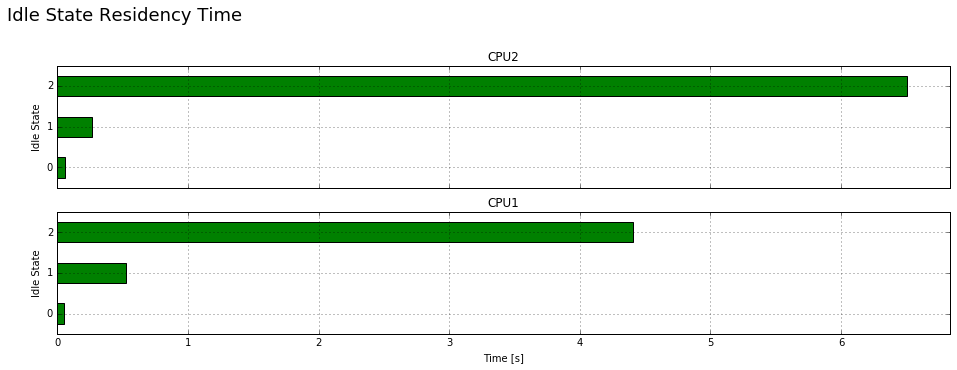

In [12]:
# Actual time spent in each idle state
ia.plotCPUIdleStateResidency([1,2])

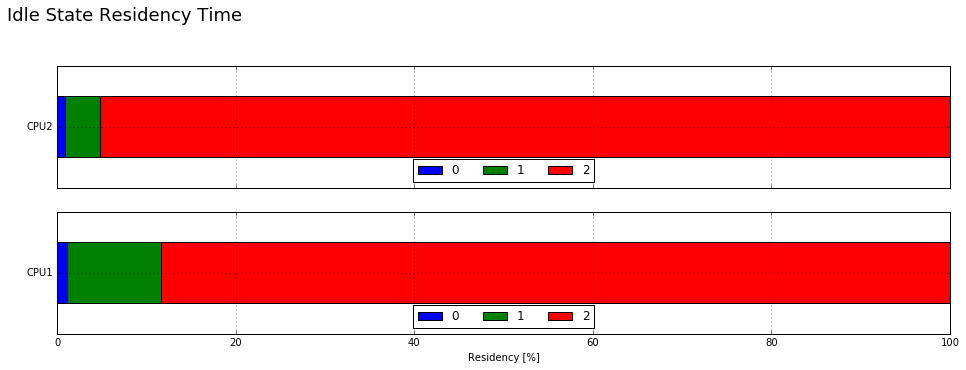

In [13]:
# Percentage of time spent in each idle state
ia.plotCPUIdleStateResidency([1,2], pct=True)

## Per-cluster Idle State Residency

In [14]:
# Idle state residency for the big cluster
trace.data_frame.cluster_idle_state_residency('big')

,time
idle_state,
0,0.101647
1,0.548901
2,4.262977


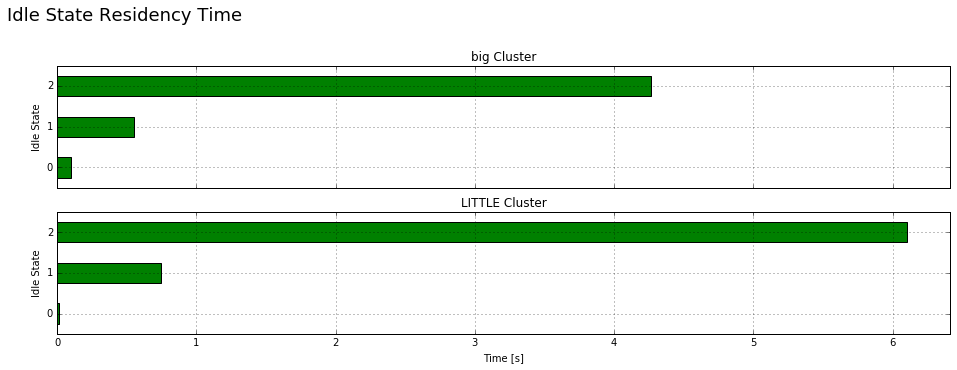

In [15]:
ia.plotClusterIdleStateResidency(['big', 'LITTLE'])

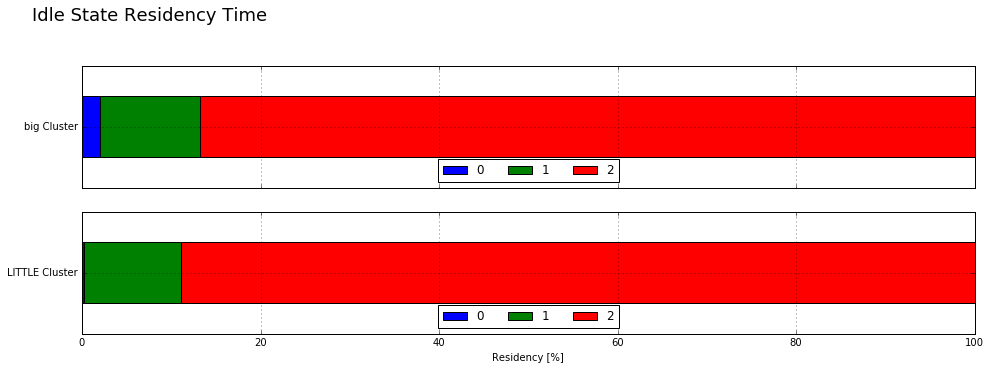

In [16]:
ia.plotClusterIdleStateResidency(['big', 'LITTLE'], pct=True)